In [32]:
import os
import math
import json
import torch
import matplotlib.pyplot as plt
from brainomni.model import BrainOmni
from braintokenizer.model import BrainTokenizer

# load braintokenizer model
def get_braintokenizer(ckpt_path) -> BrainTokenizer:
    model_config_path = os.path.join(ckpt_path, "model_cfg.json")
    with open(model_config_path) as f:
        model_config = json.load(f)
    model = BrainTokenizer(**model_config)
    checkpoint = torch.load(
        os.path.join(ckpt_path, "BrainTokenizer.pt"), map_location="cpu",weights_only=True
    )
    model.load_state_dict(checkpoint, strict=False)
    return model


# load brainomni model
def get_brainomni(ckpt_path) -> BrainOmni:
    model_config_path = os.path.join(ckpt_path, "model_cfg.json")
    with open(model_config_path) as f:
        model_config = json.load(f)
    model = BrainOmni(**model_config)
    checkpoint = torch.load(os.path.join(ckpt_path, "BrainOmni.pt"), map_location="cpu",weights_only=True)
    model.load_state_dict(checkpoint, strict=False)
    # when using omni, freeze tokenizer
    for p in model.tokenizer.parameters():
        p.requires_grad = False
    return model

In [43]:
example_data=torch.load('assets/example_data.pt',weights_only=True)
# Batch Channel Time 4s*256hz
x=example_data['x'].unsqueeze(0)
n_time_points=x.shape[-1]
# Batch Channel 6
pos=example_data['pos'].unsqueeze(0)
# Batch Channel
sensor_type=example_data['sensor_type'].unsqueeze(0)

brainomni=get_brainomni('ckpt_collection/tiny')
# extract features
features=brainomni.encode(x,pos,sensor_type)
# Batch n_neuro=16 seq_len n_dim
seq_len = 8*(math.ceil((n_time_points-512.0)/384.0)+1)
print(f'features:{features.shape}')
print(seq_len)

/usr/local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


features:torch.Size([1, 16, 24, 256])
24


In [44]:
tokenizer=get_braintokenizer('ckpt_collection/braintokenizer')
# convert into token sequences
# input will be split into 2s segments(zero padded if not enough), and processed by tokenizer in parallel
# 2s segments will output 8 token
# overlap_ratio could define the overlap between segments
features,indices=tokenizer.tokenize(x,pos,sensor_type,overlap_ratio=0.0)
# Batch n_neuro=16 n_token n_dim
print(f'features:{features.shape}')
# the indice of codebook(which we use as pseudo label in stage 2)
# Batch n_neuro=16 n_token n_codebook_layer
print(f'indices:{indices.shape}')

features:torch.Size([1, 16, 16, 256])
indices:torch.Size([1, 16, 16, 4])


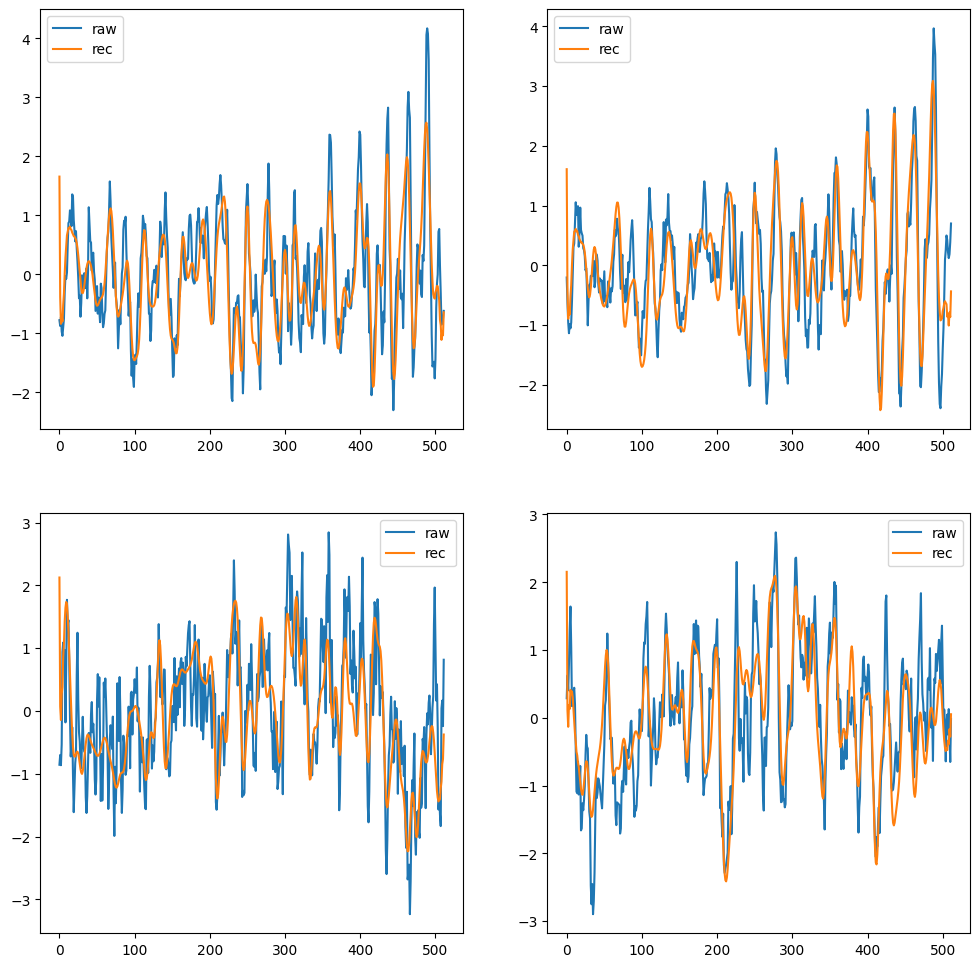

In [50]:
# reconstruction
from einops import rearrange
output_dict=tokenizer.visualize(x,pos,sensor_type)
raw=rearrange(output_dict['x'], "... D -> (...) D")
rec=rearrange(output_dict['x_rec'], "... D -> (...) D")
random_select_indices = torch.randperm(raw.shape[0])[:4]
# randomly choose some to show
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(raw[random_select_indices[i]], label="raw")
    plt.plot(rec[random_select_indices[i]], label="rec")
    plt.legend()